MODEL 1 - USERNAME_PREDICTS_GENDER

***

In [ ]:
# load packages 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

# load packages for model 
import keras  
import tensorflow as tf
from keras import metrics
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout


# float format
pd.options.display.float_format = '{:,.2f}'.format

# ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read file - load data_cleaning dataframe

path = '/content/drive/MyDrive/Colab Notebooks/VVNM/data_cleaning.csv' 
#path = '/content/drive/MyDrive/Colab Notebooks/data_cleaning.csv' 

# Read only "USER_NAME" and "USER_SEX" columns
task1_data = pd.read_csv(path, usecols = ["USER_NAME","USER_SEX"])
print(task1_data.shape)
task1_data.head(4)

(1697179, 2)


,USER_NAME,USER_SEX
0,A98815,F
1,A98815,F
2,babil,F
3,9anti1,M


In [ ]:
# Count unique users 
task1_data["USER_NAME"].nunique()

102537

In [ ]:
# Feauture engineering in order to see min and max length of user names

task1_data["LEN_NAME"] = [len(str(i)) for i in task1_data["USER_NAME"]]

print("Minimum Len:",task1_data["LEN_NAME"].min())
print("Maximum Len:",task1_data["LEN_NAME"].max())

task1_data.head(4)

Minimum Len: 1
Maximum Len: 40


,USER_NAME,USER_SEX,LEN_NAME
0,A98815,F,6
1,A98815,F,6
2,babil,F,5
3,9anti1,M,6


In [ ]:
# values with length equal to 40 will be excluded
task1_data[["LEN_NAME"]].sort_values("LEN_NAME", ascending = False)

,LEN_NAME
186673,40
275467,40
936950,20
1289926,20
1401698,20
...,...
1255448,1
1252586,1
634063,1
347643,1


In [ ]:
# Create input for model - we choose these usernames with len > 2 
# Discard the above two user with len (name) = 40

input = task1_data[(task1_data["LEN_NAME"] > 2) & (task1_data["LEN_NAME"] < 21)]

print("Minimum Len:",input["LEN_NAME"].min())
print("Maximum Len:",input["LEN_NAME"].max())
input.head(4)

Minimum Len: 3
Maximum Len: 20


,USER_NAME,USER_SEX,LEN_NAME
0,A98815,F,6
1,A98815,F,6
2,babil,F,5
3,9anti1,M,6


In [ ]:
input[["LEN_NAME"]].sort_values("LEN_NAME", ascending = False)

,LEN_NAME
363180,20
542790,20
137622,20
309604,20
137627,20
...,...
1153566,3
414034,3
414044,3
212333,3


In [ ]:
# Parameters 

maxlen = 20  

In [ ]:
task1_final = input.groupby("USER_NAME").agg({"USER_SEX":lambda x: set(x).pop()})
task1_final.reset_index(inplace=True)

print("Input final shape: ", task1_final.shape)
task1_final.head(5)

Input final shape:  (102529, 2)


,USER_NAME,USER_SEX
0,0A00001,F
1,11500017,M
2,11500018,F
3,11500019,F
4,11500020,F


In [ ]:
# create vocabulary 

names = task1_final["USER_NAME"]
vocab = set(" ".join([str(i) for i in names])) 
vocab_size = len(vocab)

In [ ]:
# create vocabulary - lower

task1_final["USER_NAME_lower"] = task1_final.USER_NAME.astype(str).str.lower()

names_lower = task1_final["USER_NAME_lower"]
vocab_lower = set(" ".join([str(i) for i in names_lower])) 
vocab_size_lower = len(vocab_lower)

In [ ]:
task1_final.head(5)

,USER_NAME,USER_SEX,USER_NAME_lower
0,0A00001,F,0a00001
1,11500017,M,11500017
2,11500018,F,11500018
3,11500019,F,11500019
4,11500020,F,11500020


In [ ]:
# vocab

In [ ]:
print(sorted(vocab, reverse = True))
print("vocab length is ",vocab_size)
print ("length of final dataframe is ",len(task1_final))

['z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '.', '-', ' ']
vocab length is  66
length of final dataframe is  102529


In [ ]:
print(sorted(vocab_lower, reverse = True))
print("vocab_lower length is ",vocab_size_lower)
print ("length of final dataframe is ",len(task1_final))

['z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '.', '-', ' ']
vocab_lower length is  40
length of final dataframe is  102529


In [ ]:
# characters dictionary 
char_dict = dict((c, i+1) for i, c in enumerate(sorted(vocab, reverse = True)))

In [ ]:
# char_dict - lower
char_dict_lower = dict((c, i+1) for i, c in enumerate(sorted(vocab_lower, reverse = True)))

In [ ]:
# # example for splitting into characters 
# 
# word = "Easy"
# x = list(word)
# print(x)

In [ ]:
task1_final["USER_NAME_CHAR"] = ""
for i in task1_final.index:
  task1_final["USER_NAME_CHAR"][i] = list(task1_final["USER_NAME"][i])

task1_final.head(5)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR
0,0A00001,F,0a00001,"[0, A, 0, 0, 0, 0, 1]"
1,11500017,M,11500017,"[1, 1, 5, 0, 0, 0, 1, 7]"
2,11500018,F,11500018,"[1, 1, 5, 0, 0, 0, 1, 8]"
3,11500019,F,11500019,"[1, 1, 5, 0, 0, 0, 1, 9]"
4,11500020,F,11500020,"[1, 1, 5, 0, 0, 0, 2, 0]"


In [ ]:
# create "USER_NAME_CHAR" - lower 

task1_final["USER_NAME_CHAR_lower"] = ""
for i in task1_final.index:
  task1_final["USER_NAME_CHAR_lower"][i] = list(task1_final["USER_NAME_lower"][i])

task1_final.head(4)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR,USER_NAME_CHAR_lower
0,0A00001,F,0a00001,"[0, A, 0, 0, 0, 0, 1]","[0, a, 0, 0, 0, 0, 1]"
1,11500017,M,11500017,"[1, 1, 5, 0, 0, 0, 1, 7]","[1, 1, 5, 0, 0, 0, 1, 7]"
2,11500018,F,11500018,"[1, 1, 5, 0, 0, 0, 1, 8]","[1, 1, 5, 0, 0, 0, 1, 8]"
3,11500019,F,11500019,"[1, 1, 5, 0, 0, 0, 1, 9]","[1, 1, 5, 0, 0, 0, 1, 9]"


In [ ]:
# Create CHAR_SEQUENCES with mapped elements from the characters' dictionary 

task1_final["CHAR_SEQUENCES"] = task1_final["USER_NAME"].apply(lambda s: [char_dict[i] for i in list(s)])

In [ ]:
# Create CHAR_SEQUENCES with mapped elements from the characters lower dictionary - lower

task1_final["CHAR_SEQUENCES_lower"] = task1_final["USER_NAME_lower"].apply(lambda s: [char_dict_lower[i] for i in list(s)])

In [ ]:
task1_final.head(5)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR,USER_NAME_CHAR_lower,CHAR_SEQUENCES,CHAR_SEQUENCES_lower
0,0A00001,F,0a00001,"[0, A, 0, 0, 0, 0, 1]","[0, a, 0, 0, 0, 0, 1]","[63, 53, 63, 63, 63, 63, 62]","[37, 26, 37, 37, 37, 37, 36]"
1,11500017,M,11500017,"[1, 1, 5, 0, 0, 0, 1, 7]","[1, 1, 5, 0, 0, 0, 1, 7]","[62, 62, 58, 63, 63, 63, 62, 56]","[36, 36, 32, 37, 37, 37, 36, 30]"
2,11500018,F,11500018,"[1, 1, 5, 0, 0, 0, 1, 8]","[1, 1, 5, 0, 0, 0, 1, 8]","[62, 62, 58, 63, 63, 63, 62, 55]","[36, 36, 32, 37, 37, 37, 36, 29]"
3,11500019,F,11500019,"[1, 1, 5, 0, 0, 0, 1, 9]","[1, 1, 5, 0, 0, 0, 1, 9]","[62, 62, 58, 63, 63, 63, 62, 54]","[36, 36, 32, 37, 37, 37, 36, 28]"
4,11500020,F,11500020,"[1, 1, 5, 0, 0, 0, 2, 0]","[1, 1, 5, 0, 0, 0, 2, 0]","[62, 62, 58, 63, 63, 63, 61, 63]","[36, 36, 32, 37, 37, 37, 35, 37]"


In [ ]:
# padding function 

def padding(array):
  if len(array) >= 20:
    return array
  s = 20-len(array)
  return array + ([0]*s) 

In [ ]:
# check padding function
print(padding([1,2,3])) # example array
print(len(padding([1,2,3]))) # len of padded array

[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
20


In [ ]:
# create PAD_CHAR_SEQUENCES with padding function 
task1_final["PAD_CHAR_SEQUENCES"] = task1_final["CHAR_SEQUENCES"].apply(padding)

In [ ]:
# create PAD_CHAR_SEQUENCES with padding function 
task1_final["PAD_CHAR_SEQUENCES_lower"] = task1_final["CHAR_SEQUENCES_lower"].apply(padding)

In [ ]:
task1_final["PAD_CHAR_SEQUENCES"] 

0         [63, 53, 63, 63, 63, 63, 62, 0, 0, 0, 0, 0, 0,...
1         [62, 62, 58, 63, 63, 63, 62, 56, 0, 0, 0, 0, 0...
2         [62, 62, 58, 63, 63, 63, 62, 55, 0, 0, 0, 0, 0...
3         [62, 62, 58, 63, 63, 63, 62, 54, 0, 0, 0, 0, 0...
4         [62, 62, 58, 63, 63, 63, 61, 63, 0, 0, 0, 0, 0...
                                ...                        
102524    [1, 2, 20, 12, 54, 61, 54, 61, 0, 0, 0, 0, 0, ...
102525    [1, 2, 20, 12, 8, 56, 56, 0, 0, 0, 0, 0, 0, 0,...
102526    [1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,...
102527    [1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ...
102528    [1, 1, 9, 62, 59, 62, 59, 0, 0, 0, 0, 0, 0, 0,...
Name: PAD_CHAR_SEQUENCES, Length: 102529, dtype: object

In [ ]:
task1_final["PAD_CHAR_SEQUENCES_lower"] 

0         [37, 26, 37, 37, 37, 37, 36, 0, 0, 0, 0, 0, 0,...
1         [36, 36, 32, 37, 37, 37, 36, 30, 0, 0, 0, 0, 0...
2         [36, 36, 32, 37, 37, 37, 36, 29, 0, 0, 0, 0, 0...
3         [36, 36, 32, 37, 37, 37, 36, 28, 0, 0, 0, 0, 0...
4         [36, 36, 32, 37, 37, 37, 35, 37, 0, 0, 0, 0, 0...
                                ...                        
102524    [1, 2, 20, 12, 28, 35, 28, 35, 0, 0, 0, 0, 0, ...
102525    [1, 2, 20, 12, 8, 30, 30, 0, 0, 0, 0, 0, 0, 0,...
102526    [1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,...
102527    [1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ...
102528    [1, 1, 9, 36, 33, 36, 33, 0, 0, 0, 0, 0, 0, 0,...
Name: PAD_CHAR_SEQUENCES_lower, Length: 102529, dtype: object

In [ ]:
task1_final.head(5)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR,USER_NAME_CHAR_lower,CHAR_SEQUENCES,CHAR_SEQUENCES_lower,PAD_CHAR_SEQUENCES,PAD_CHAR_SEQUENCES_lower
0,0A00001,F,0a00001,"[0, A, 0, 0, 0, 0, 1]","[0, a, 0, 0, 0, 0, 1]","[63, 53, 63, 63, 63, 63, 62]","[37, 26, 37, 37, 37, 37, 36]","[63, 53, 63, 63, 63, 63, 62, 0, 0, 0, 0, 0, 0,...","[37, 26, 37, 37, 37, 37, 36, 0, 0, 0, 0, 0, 0,..."
1,11500017,M,11500017,"[1, 1, 5, 0, 0, 0, 1, 7]","[1, 1, 5, 0, 0, 0, 1, 7]","[62, 62, 58, 63, 63, 63, 62, 56]","[36, 36, 32, 37, 37, 37, 36, 30]","[62, 62, 58, 63, 63, 63, 62, 56, 0, 0, 0, 0, 0...","[36, 36, 32, 37, 37, 37, 36, 30, 0, 0, 0, 0, 0..."
2,11500018,F,11500018,"[1, 1, 5, 0, 0, 0, 1, 8]","[1, 1, 5, 0, 0, 0, 1, 8]","[62, 62, 58, 63, 63, 63, 62, 55]","[36, 36, 32, 37, 37, 37, 36, 29]","[62, 62, 58, 63, 63, 63, 62, 55, 0, 0, 0, 0, 0...","[36, 36, 32, 37, 37, 37, 36, 29, 0, 0, 0, 0, 0..."
3,11500019,F,11500019,"[1, 1, 5, 0, 0, 0, 1, 9]","[1, 1, 5, 0, 0, 0, 1, 9]","[62, 62, 58, 63, 63, 63, 62, 54]","[36, 36, 32, 37, 37, 37, 36, 28]","[62, 62, 58, 63, 63, 63, 62, 54, 0, 0, 0, 0, 0...","[36, 36, 32, 37, 37, 37, 36, 28, 0, 0, 0, 0, 0..."
4,11500020,F,11500020,"[1, 1, 5, 0, 0, 0, 2, 0]","[1, 1, 5, 0, 0, 0, 2, 0]","[62, 62, 58, 63, 63, 63, 61, 63]","[36, 36, 32, 37, 37, 37, 35, 37]","[62, 62, 58, 63, 63, 63, 61, 63, 0, 0, 0, 0, 0...","[36, 36, 32, 37, 37, 37, 35, 37, 0, 0, 0, 0, 0..."


In [ ]:
# check
task1_final.tail(5)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR,USER_NAME_CHAR_lower,CHAR_SEQUENCES,CHAR_SEQUENCES_lower,PAD_CHAR_SEQUENCES,PAD_CHAR_SEQUENCES_lower
102524,zygo9292,F,zygo9292,"[z, y, g, o, 9, 2, 9, 2]","[z, y, g, o, 9, 2, 9, 2]","[1, 2, 20, 12, 54, 61, 54, 61]","[1, 2, 20, 12, 28, 35, 28, 35]","[1, 2, 20, 12, 54, 61, 54, 61, 0, 0, 0, 0, 0, ...","[1, 2, 20, 12, 28, 35, 28, 35, 0, 0, 0, 0, 0, ..."
102525,zygos77,M,zygos77,"[z, y, g, o, s, 7, 7]","[z, y, g, o, s, 7, 7]","[1, 2, 20, 12, 8, 56, 56]","[1, 2, 20, 12, 8, 30, 30]","[1, 2, 20, 12, 8, 56, 56, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 20, 12, 8, 30, 30, 0, 0, 0, 0, 0, 0, 0,..."
102526,zzannas,M,zzannas,"[z, z, a, n, n, a, s]","[z, z, a, n, n, a, s]","[1, 1, 26, 13, 13, 26, 8]","[1, 1, 26, 13, 13, 26, 8]","[1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,..."
102527,zzouraris,F,zzouraris,"[z, z, o, u, r, a, r, i, s]","[z, z, o, u, r, a, r, i, s]","[1, 1, 12, 6, 9, 26, 9, 18, 8]","[1, 1, 12, 6, 9, 26, 9, 18, 8]","[1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ...","[1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ..."
102528,zzr1414,F,zzr1414,"[z, z, r, 1, 4, 1, 4]","[z, z, r, 1, 4, 1, 4]","[1, 1, 9, 62, 59, 62, 59]","[1, 1, 9, 36, 33, 36, 33]","[1, 1, 9, 62, 59, 62, 59, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 9, 36, 33, 36, 33, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
# create empty columns USER_SEX_ID
task1_final["USER_SEX_ENCODED"] = ""

In [ ]:
# create USER_SEX_ID

for i in task1_final.index:
  if task1_final["USER_SEX"][i] == "F":
    task1_final["USER_SEX_ENCODED"][i] = 0
  else:
    task1_final["USER_SEX_ENCODED"][i] = 1

In [ ]:
# cheack 
task1_final.tail(5)

,USER_NAME,USER_SEX,USER_NAME_lower,USER_NAME_CHAR,USER_NAME_CHAR_lower,CHAR_SEQUENCES,CHAR_SEQUENCES_lower,PAD_CHAR_SEQUENCES,PAD_CHAR_SEQUENCES_lower,USER_SEX_ENCODED
102524,zygo9292,F,zygo9292,"[z, y, g, o, 9, 2, 9, 2]","[z, y, g, o, 9, 2, 9, 2]","[1, 2, 20, 12, 54, 61, 54, 61]","[1, 2, 20, 12, 28, 35, 28, 35]","[1, 2, 20, 12, 54, 61, 54, 61, 0, 0, 0, 0, 0, ...","[1, 2, 20, 12, 28, 35, 28, 35, 0, 0, 0, 0, 0, ...",0
102525,zygos77,M,zygos77,"[z, y, g, o, s, 7, 7]","[z, y, g, o, s, 7, 7]","[1, 2, 20, 12, 8, 56, 56]","[1, 2, 20, 12, 8, 30, 30]","[1, 2, 20, 12, 8, 56, 56, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 20, 12, 8, 30, 30, 0, 0, 0, 0, 0, 0, 0,...",1
102526,zzannas,M,zzannas,"[z, z, a, n, n, a, s]","[z, z, a, n, n, a, s]","[1, 1, 26, 13, 13, 26, 8]","[1, 1, 26, 13, 13, 26, 8]","[1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 26, 13, 13, 26, 8, 0, 0, 0, 0, 0, 0, 0,...",1
102527,zzouraris,F,zzouraris,"[z, z, o, u, r, a, r, i, s]","[z, z, o, u, r, a, r, i, s]","[1, 1, 12, 6, 9, 26, 9, 18, 8]","[1, 1, 12, 6, 9, 26, 9, 18, 8]","[1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ...","[1, 1, 12, 6, 9, 26, 9, 18, 8, 0, 0, 0, 0, 0, ...",0
102528,zzr1414,F,zzr1414,"[z, z, r, 1, 4, 1, 4]","[z, z, r, 1, 4, 1, 4]","[1, 1, 9, 62, 59, 62, 59]","[1, 1, 9, 36, 33, 36, 33]","[1, 1, 9, 62, 59, 62, 59, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 9, 36, 33, 36, 33, 0, 0, 0, 0, 0, 0, 0,...",0


In [ ]:
X = np.vstack(task1_final['PAD_CHAR_SEQUENCES'])
Y = np.vstack(task1_final['USER_SEX_ENCODED'])

In [ ]:
X_lower = np.vstack(task1_final['PAD_CHAR_SEQUENCES_lower'])

In [ ]:
print(X.shape)
print(X_lower.shape)
print(Y.shape)

(102529, 20)
(102529, 20)
(102529, 1)


In [ ]:
#from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, Y)

print(sss)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, test_index in sss.split(X, Y):
     print("REST:", train_index, "TEST:", test_index)
     X_rest, X_test = np.asarray(X[train_index]), np.asarray(X[test_index])
     X_rest_lower, X_test_lower = np.asarray(X_lower[train_index]), np.asarray(X_lower[test_index])
     Y_rest, Y_test = np.asarray(Y[train_index]), np.asarray(Y[test_index])

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("X_rest shape:", X_rest.shape)
print("X_rest_lower shape:", X_rest_lower.shape)
print("Y_rest shape:", Y_rest.shape)
print("X_test shape:", X_test.shape)
print("X_test_lower shape:", X_test_lower.shape)
print("Y_test shape:", Y_test.shape)


StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
REST: [39931 57167 20027 ...  1107 50431 96835] TEST: [ 8917  8492 96338 ... 14588 34226 90277]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X_rest shape: (82023, 20)
X_rest_lower shape: (82023, 20)
Y_rest shape: (82023, 1)
X_test shape: (20506, 20)
X_test_lower shape: (20506, 20)
Y_test shape: (20506, 1)


In [ ]:
#from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss1.get_n_splits(X_rest, Y_rest)

print(sss1)
StratifiedShuffleSplit(n_splits=1, random_state=0)
for train_index, val_index in sss1.split(X_rest, Y_rest):
     print("TRAIN:", train_index, "VAL:", val_index)
     X_train, X_val = np.asarray(X_rest[train_index]), np.asarray(X_rest[val_index])
     X_train_lower, X_val_lower = np.asarray(X_rest_lower[train_index]), np.asarray(X_rest_lower[val_index])
     Y_train, Y_val = np.asarray(Y_rest[train_index]), np.asarray(Y_rest[val_index])

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("X_train shape:", X_train.shape)
print("X_train_lower shape:", X_train_lower.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("X_val_lower shape:", X_val_lower.shape)
print("Y_val shape:", Y_val.shape)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)
TRAIN: [50455 13409 16945 ... 17917 38112 18684] VAL: [62834 47075 18557 ... 63854 39775 79551]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X_train shape: (61517, 20)
X_train_lower shape: (61517, 20)
Y_train shape: (61517, 1)
X_val shape: (20506, 20)
X_val_lower shape: (20506, 20)
Y_val shape: (20506, 1)


MODEL BUILD

***

In [ ]:
# early stopping callback 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights = True) 

In [ ]:
# checkpoint callback 

filepath = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/checkpoint_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# general model 

model = Sequential()
model.add(Embedding(vocab_size + 1, 50, input_length= maxlen))
model.add(LSTM(256, return_sequences= True))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences= False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.001), metrics=["binary_accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            3350      
_________________________________________________________________
lstm (LSTM)                  (None, 20, 256)           314368    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 843,287
Trainable params: 843,287
Non-trainable params: 0
__________________________________________________

In [ ]:
model_fit = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=64, callbacks=[callback,checkpoint])

Epoch 1/50
962/962 [==============================] - 18s 11ms/step - loss: 0.6936 - binary_accuracy: 0.4979 - val_loss: 0.6934 - val_binary_accuracy: 0.4996

Epoch 00001: val_loss improved from inf to 0.69339, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/checkpoint_model.h5
Epoch 2/50
962/962 [==============================] - 10s 10ms/step - loss: 0.6934 - binary_accuracy: 0.5005 - val_loss: 0.6932 - val_binary_accuracy: 0.4997

Epoch 00002: val_loss improved from 0.69339 to 0.69319, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/checkpoint_model.h5
Epoch 3/50
962/962 [==============================] - 10s 10ms/step - loss: 0.6933 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.5020

Epoch 00003: val_loss improved from 0.69319 to 0.69316, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/checkpoint_model.h5
Epoch 4/50
962/962 [==============================] - 10s 1

In [ ]:
# save model and architecture to single file

filepath1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/Saved_fmodel.h5'
#model.save(filepath1, overwrite= True)

In [ ]:
# save and load the weights of the model

filepath2 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1/Saved_fmodel_weights.h5'

#model.save_weights(filepath2, overwrite= True)

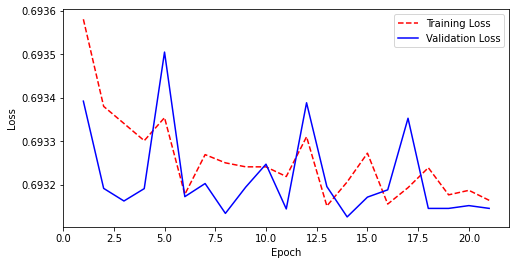

In [ ]:
# Get training and test loss histories
training_loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [ ]:
# evaluation
score = model.evaluate(X_test, Y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.6931566596031189
Test accuracy: 0.49995124340057373


In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

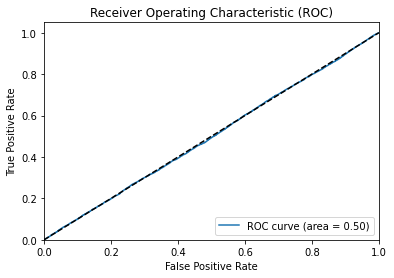

In [ ]:
# prediction

pred = model.predict(X_test) 
plot_roc(pred, Y_test)

In [ ]:
# check first five predictions 

pred_5 = np.argmax(pred, axis = 1)[:5] 
label_5 = np.argmax(Y_test,axis = 1)[:5] 

print(pred_5) 
print(label_5)

[0 0 0 0 0]
[0 0 0 0 0]


In [ ]:
# Usually binary classifiers are implemented with one output node and Sigmoid activation function.
# In that case the output you get is the predicted probability of an observation being of class 1 (compared to 0). 
# If you want a probability distribution you can simply pair that y predicted, with 1-y, meaning "the probability of the other class". 

In [ ]:
preds = model.predict(X_test)
class_one_male = preds > 0.5 

# The true elements of class_one correspond to samples labeled with one (i.e. positive class - male).
# Get count of True elements in a numpy array

count = np.sum(class_one_male)
print('Print count of True elements in array: ', count)

Print count of True elements in array:  4721


In [ ]:
# to find the accuracy of your predictions you can easily compare class_one with the true labels:

acc = np.mean(class_one_male == Y_test)
acc

0.4999512337852336

In [ ]:
# load model - section 

# loaded_model = load_model(filepath1)


In [ ]:
#loaded_model.summary()

In [ ]:
# evaluation of loaded model
# score_load = loaded_model.evaluate(X_test, Y_test, verbose = 0) 
# 
# print('Test loss:', score_load[0]) 
# print('Test accuracy:', score_load[1])

MODEL BUILD - lower

In [ ]:
# model1 - lower 

model1_lower = Sequential()
model1_lower.add(Embedding(vocab_size_lower + 1, 50, input_length= maxlen))
model1_lower.add(LSTM(256, return_sequences= True))
model1_lower.add(Dropout(0.3))
model1_lower.add(LSTM(256, return_sequences= False))
model1_lower.add(Dropout(0.3))
model1_lower.add(Dense(1, activation='sigmoid'))
model1_lower.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.001), metrics=["binary_accuracy"])
print(model1_lower.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            2050      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 256)           314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 841,987
Trainable params: 841,987
Non-trainable params: 0
________________________________________________

In [ ]:
callback_l = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, restore_best_weights = True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath_l1 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1_lower/checkpoint_model1_lower.h5'

checkpoint_l = ModelCheckpoint(filepath_l1, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
model1_lower_fit = model1_lower.fit(X_train_lower, Y_train, validation_data=(X_val_lower, Y_val), epochs=50, batch_size=64, callbacks=[callback_l,checkpoint_l])

Epoch 1/50
962/962 [==============================] - 13s 11ms/step - loss: 0.6935 - binary_accuracy: 0.5008 - val_loss: 0.6963 - val_binary_accuracy: 0.5004

Epoch 00001: val_loss improved from inf to 0.69634, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1_lower/checkpoint_model1_lower.h5
Epoch 2/50
962/962 [==============================] - 10s 10ms/step - loss: 0.6934 - binary_accuracy: 0.5008 - val_loss: 0.6936 - val_binary_accuracy: 0.5004

Epoch 00002: val_loss improved from 0.69634 to 0.69360, saving model to /content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1_lower/checkpoint_model1_lower.h5
Epoch 3/50
962/962 [==============================] - 10s 10ms/step - loss: 0.6933 - binary_accuracy: 0.5014 - val_loss: 0.6938 - val_binary_accuracy: 0.5004

Epoch 00003: val_loss did not improve from 0.69360
Epoch 4/50
962/962 [==============================] - 10s 10ms/step - loss: 0.6934 - binary_accuracy: 0.5007 - val_loss: 0.6932 - val_bina

In [ ]:
# save model and architecture to single file - lower 

filepath_l2 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1_lower/Saved_fmodel1_lower.h5'
#model.save(filepath_l2, overwrite= True)

In [ ]:
# save and load the weights of the model - lower 

filepath_l3 = '/content/drive/MyDrive/Colab Notebooks/VVNM/Saved_Models/model1_lower/Saved_fmodel1_lower_weights.h5'

#model.save_weights(filepath_l3, overwrite= True)

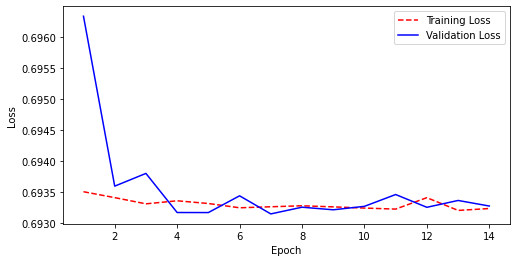

In [ ]:
# Get training and test loss histories - lower 

training_loss = model1_lower_fit.history['loss']
validation_loss = model1_lower_fit.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

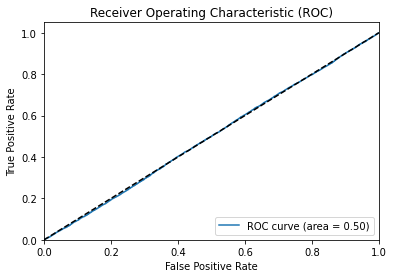

In [ ]:
# prediction - lower 

pred_lower = model1_lower.predict(X_test_lower) 
plot_roc(pred_lower, Y_test)

In [ ]:
# check first five predictions 

pred_5_l = np.argmax(pred_lower, axis = 1)[:5] 
label_5_l = np.argmax(Y_test,axis = 1)[:5] 

print(pred_5_l) 
print(label_5_l)

[0 0 0 0 0]
[0 0 0 0 0]


In [ ]:
preds_l = model1_lower.predict(X_test_lower)
class_one_male_l = preds_l > 0.5 

# The true elements of class_one correspond to samples labeled with one (i.e. positive class - male).
# Get count of True elements in a numpy array

count_l = np.sum(class_one_male_l)
print('Print count of True elements in array: ', count_l)

Print count of True elements in array:  12072


In [ ]:
# to find the accuracy of your predictions you can easily compare class_one with the true labels:

acc_l = np.mean(class_one_male_l == Y_test)
acc_l

0.502145713449722

In [ ]:
# load model - lower 

# loaded_model_l = load_model(filepath_l2)

In [ ]:
#loaded_model_l.summary()

In [ ]:
# evaluation of loaded model_l

# score_load_l = loaded_model_l.evaluate(X_test_lower, Y_test, verbose = 0) 
# 
# print('Test loss:', score_load_l[0]) 
# print('Test accuracy:', score_load_l[1])

In [ ]:
# evaluation - lower 

score_l = model1_lower.evaluate(X_test_lower, Y_test, verbose = 0) 

print('Test loss:', score_l[0]) 
print('Test accuracy:', score_l[1])

Test loss: 0.6931668519973755
Test accuracy: 0.5021457076072693
